# Customer Segmentation - Clustering

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
customers = pd.read_csv('../Datasets/Customers.csv')
transactions = pd.read_csv('../Datasets/Transactions.csv')
products = pd.read_csv('../Datasets/Products.csv')

In [4]:
# Merge transactions with products
transactions_products = pd.merge(transactions, products, on='ProductID', how='left')

In [5]:
# Merge transactions with customers
final_data = pd.merge(transactions_products, customers, on='CustomerID', how='left')

In [6]:
# Aggregate transaction data for customers
customer_features = final_data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'Price_y': 'mean',
    'TotalValue': 'sum',
    'Category': lambda x: ' '.join(x)  # Concatenate product categories
}).reset_index()


In [8]:
# Encode product categories
encoder = OneHotEncoder()
encoded_categories = encoder.fit_transform(customer_features[['Category']]).toarray()

In [9]:
encoded_categories_df = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(['Category']))

In [11]:
customer_features = pd.concat([customer_features, encoded_categories_df], axis=1).drop(columns=['Category'])

In [12]:
# Normalize numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.iloc[:, 1:])  # Exclude customer_id

# K-Means Clustering

In [13]:
db_scores = []
clusters = range(2, 11)

In [15]:
import warnings
warnings.filterwarnings('ignore')

for k in clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, labels)
    db_scores.append(db_index)

# Optimal number of clusters based on DB Index
optimal_k = clusters[np.argmin(db_scores)]
print(f"Optimal number of clusters: {optimal_k}")

Optimal number of clusters: 5


In [16]:
# Final clustering with optimal_k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_labels = kmeans.fit_predict(scaled_features)

In [17]:
# Add cluster labels to the dataset
customer_features['Cluster'] = final_labels

# Visualizations

In [18]:
# Reducing dimensions for visualization

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_features)

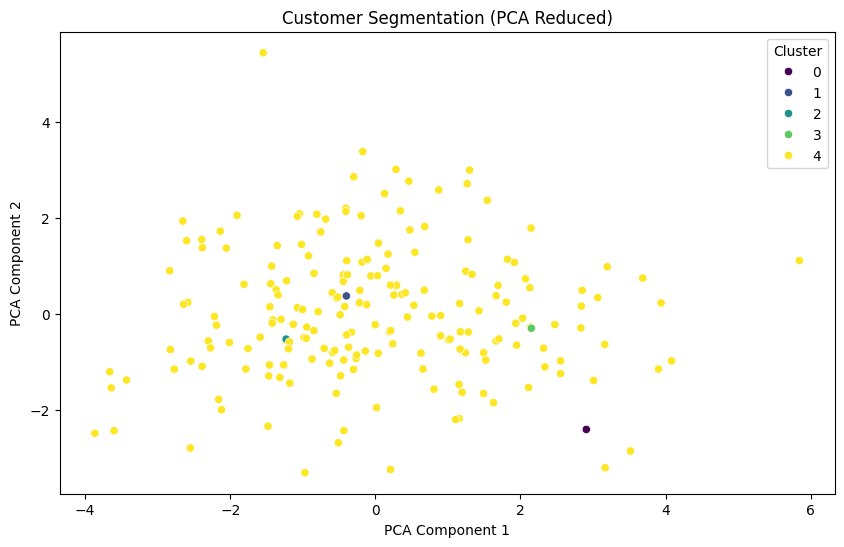

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=final_labels, palette='viridis')
plt.title('Customer Segmentation (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Metrics

In [25]:
from sklearn.metrics import silhouette_score

In [26]:
silhouette_avg = silhouette_score(scaled_features, final_labels)

print("Davies-Bouldin Index for Optimal Clusters:", min(db_scores))
print("Silhouette Score:", silhouette_avg)
print("Number of Clusters:", optimal_k)

Davies-Bouldin Index for Optimal Clusters: 0.9252322177528702
Silhouette Score: 0.02863924368427505
Number of Clusters: 5
